# Datasets para modelos

In [37]:
# Números
import pandas as pd
import numpy as np

from bayes_opt import BayesianOptimization
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt

In [2]:
path_original = "..\\data\\original\\"
path_proc =  "..\\data\\processed\\"
path_ext = "..\\data\\external\\"

# Funciones para la búsqueda bayesiana
fuente: https://www.kdnuggets.com/2019/07/xgboost-random-forest-bayesian-optimisation.html

In [9]:
#Bayesian optimization
def bayesian_optimization(dataset, function, parameters):
   X_train, y_train, X_test, y_test = dataset
   n_iterations = 100
   gp_params = {"alpha": 1e-4}

   BO = BayesianOptimization(function, parameters)
   BO.maximize(n_iter=n_iterations, **gp_params)

   return BO.max

In [82]:
# Optimization function
def rfc_optimization(cv_splits):
    def function(n_estimators, max_depth, min_samples_split):
        return cross_val_score(
               RandomForestClassifier(
                   n_estimators=int(max(n_estimators,0)),                                                               
                   max_depth=int(max(max_depth,1)),
                   min_samples_split=int(max(min_samples_split,2)), 
                   n_jobs=-1, 
                   random_state=55,   
                   class_weight="balanced"),  
               X=X_train, 
               y=y_train, 
               cv=cv_splits,
               scoring="roc_auc",
               n_jobs=-1).mean()

    parameters = {"n_estimators": (5000, 10000),
                  "max_depth": (100, 1000),
                  "min_samples_split": (2, 500)}
    
    return function, parameters

In [83]:
#Train
def train(X_train, y_train, X_test, y_test, function, parameters):
    dataset = (X_train, y_train, X_test, y_test)
    cv_splits = 5
    
    best_solution = bayesian_optimization(dataset, function, parameters)      
    params = best_solution["params"]

    model = RandomForestClassifier(
             n_estimators=int(max(params["n_estimators"], 0)),
             max_depth=int(max(params["max_depth"], 1)),
             min_samples_split=int(max(params["min_samples_split"], 2)), 
             n_jobs=-1, 
             random_state=55,   
             class_weight="balanced")

    model.fit(X_train, y_train)
    
    return model

# Datasets

In [11]:
# Dev
dev = pd.read_csv(path_proc + "data_bal_dummy_dev.csv").set_index("id")
dev.drop("BMI",axis=1, inplace=True)
# Test
test = pd.read_csv(path_proc + "data_bal_dummy_test.csv").set_index("id")
test.drop("BMI",axis=1, inplace=True)

In [12]:
# Train test split
X_dev = dev.drop("target",axis=1).copy()
y_dev = dev.target.copy()
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.2, random_state=55)

# Random Forest

## Búsqueda

In [84]:
function, parameters = rfc_optimization(5)
parameters

{'n_estimators': (5000, 10000),
 'max_depth': (100, 1000),
 'min_samples_split': (2, 500)}

In [85]:
model = train(X_train, y_train, X_val, y_val, function, parameters)

  |  492.6    |  9.87e+03 |
|  311      |  0.737    |  990.9    |  499.2    |  9.834e+0 |
|  312      |  0.7371   |  934.7    |  498.8    |  9.953e+0 |
|  313      |  0.7367   |  986.0    |  499.4    |  5.105e+0 |
|  314      |  0.7366   |  122.1    |  497.8    |  5.023e+0 |
|  315      |  0.7367   |  992.2    |  496.4    |  5.035e+0 |
|  316      |  0.737    |  110.7    |  499.4    |  8.42e+03 |
|  317      |  0.7368   |  999.3    |  498.1    |  7.631e+0 |
|  318      |  0.7367   |  986.7    |  499.2    |  5.101e+0 |
|  319      |  0.7371   |  107.1    |  499.2    |  9.986e+0 |
|  320      |  0.737    |  997.7    |  495.3    |  8.049e+0 |
|  321      |  0.7367   |  947.5    |  500.0    |  5.064e+0 |
|  322      |  0.7371   |  989.1    |  498.6    |  9.988e+0 |
|  323      |  0.7369   |  104.1    |  498.8    |  7.754e+0 |
|  324      |  0.737    |  104.0    |  498.6    |  9.856e+0 |
|  325      |  0.7367   |  101.4    |  500.0    |  6.965e+0 |
|  326      |  0.7369   |  103.6    |  498

In [86]:
model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=234, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=245,
                       min_weight_fraction_leaf=0.0, n_estimators=6119,
                       n_jobs=-1, oob_score=False, random_state=55, verbose=0,
                       warm_start=False)

## Test

### Modelo 0
- Se optimizan n_estimators, max_depth, min_samples_split.
- Se usan todas las variables.

In [108]:
model0 = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=15,
                       min_weight_fraction_leaf=0.0, n_estimators=645,
                       n_jobs=-1, oob_score=False, random_state=55, verbose=0,
                       warm_start=False)

In [109]:
X_test = test.drop("target",axis=1).copy()
y_test = test.target.copy()

In [110]:
model0.fit(X_dev, y_dev)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=15,
                       min_weight_fraction_leaf=0.0, n_estimators=645,
                       n_jobs=-1, oob_score=False, random_state=55, verbose=0,
                       warm_start=False)

<BarContainer object of 55 artists>

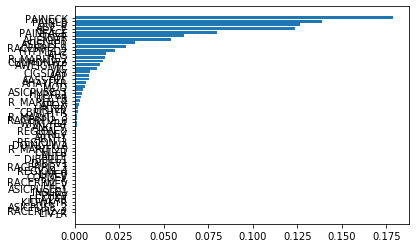

In [111]:
features0 = list(X_dev.columns)
importances0 = list(model0.feature_importances_)
df_importances0 = pd.DataFrame({"feature":features0, "importance":importances0})

temp = df_importances0.sort_values("importance")
plt.barh(temp.feature, temp.importance)

In [ ]:
temp

In [22]:
y_pred0 = model0.predict(X_test)

In [23]:
roc_auc_score(y_test, y_pred0)

0.705265410958904

In [24]:
print(classification_report(y_test, y_pred0))

precision    recall  f1-score   support

           0       0.72      0.72      0.72       320
           1       0.69      0.69      0.69       292

    accuracy                           0.71       612
   macro avg       0.71      0.71      0.71       612
weighted avg       0.71      0.71      0.71       612



### Modelo 1
Sobre los parámetros encontrados para modelo 0 se modifican:
- criterio: entropy
- profundidad del árbol: sin límite
- estimadores: muchos más, 10000

In [77]:
model1 = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=15,
                       min_weight_fraction_leaf=0.0, n_estimators=10000,
                       n_jobs=-1, oob_score=False, random_state=55, verbose=0,
                       warm_start=False)

In [78]:
model1.fit(X_dev, y_dev)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=15,
                       min_weight_fraction_leaf=0.0, n_estimators=10000,
                       n_jobs=-1, oob_score=False, random_state=55, verbose=0,
                       warm_start=False)

<BarContainer object of 55 artists>

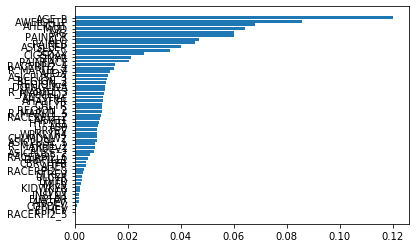

In [112]:
features1 = list(X_dev.columns)
importances1 = list(model1.feature_importances_)
df_importances1 = pd.DataFrame({"feature":features1, "importance":importances1})

temp = df_importances1.sort_values("importance")
plt.barh(temp.feature, temp.importance)

In [79]:
y_pred1 = model1.predict(X_test)

In [80]:
roc_auc_score(y_test, y_pred1)

0.7210402397260274

In [81]:
print(classification_report(y_test, y_pred1))

precision    recall  f1-score   support

           0       0.73      0.75      0.74       320
           1       0.71      0.70      0.70       292

    accuracy                           0.72       612
   macro avg       0.72      0.72      0.72       612
weighted avg       0.72      0.72      0.72       612



### Modelo 2
Se buscan nuevos parámetros, esta vez entre límites maayores:
- profundidad del árbol entre 100 y 5000
- estimadores entre 5000 y 10000

In [87]:
model2 = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=234, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=245,
                       min_weight_fraction_leaf=0.0, n_estimators=6119,
                       n_jobs=-1, oob_score=False, random_state=55, verbose=0,
                       warm_start=False)

In [88]:
model2.fit(X_dev, y_dev)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=234, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=245,
                       min_weight_fraction_leaf=0.0, n_estimators=6119,
                       n_jobs=-1, oob_score=False, random_state=55, verbose=0,
                       warm_start=False)

<BarContainer object of 55 artists>

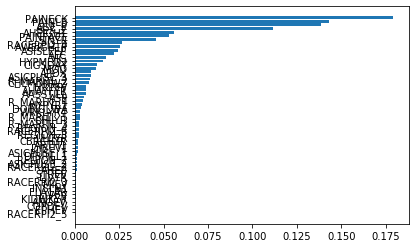

In [113]:
features2 = list(X_dev.columns)
importances2 = list(model2.feature_importances_)
df_importances2 = pd.DataFrame({"feature":features2, "importance":importances2})

temp = df_importances2.sort_values("importance")
plt.barh(temp.feature, temp.importance)

In [89]:
y_pred2 = model2.predict(X_test)

In [90]:
roc_auc_score(y_test, y_pred2)

0.7220890410958903

In [91]:
print(classification_report(y_test, y_pred2))

precision    recall  f1-score   support

           0       0.74      0.72      0.73       320
           1       0.70      0.72      0.71       292

    accuracy                           0.72       612
   macro avg       0.72      0.72      0.72       612
weighted avg       0.72      0.72      0.72       612



### Modelo 3
Se modifican los parámetros encontrados en el modelo 2:
- criterio entropy
- Profundidad de árbol sin límite
- Mayor cantidad de estimadores (10k)

In [102]:
model3 = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=245,
                       min_weight_fraction_leaf=0.0, n_estimators=10000,
                       n_jobs=-1, oob_score=False, random_state=55, verbose=0,
                       warm_start=False)

In [103]:
model3.fit(X_dev, y_dev)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=245,
                       min_weight_fraction_leaf=0.0, n_estimators=10000,
                       n_jobs=-1, oob_score=False, random_state=55, verbose=0,
                       warm_start=False)

In [104]:
y_pred3 = model3.predict(X_test)

In [105]:
roc_auc_score(y_test, y_pred3)

0.7220890410958903

In [106]:
print(classification_report(y_test, y_pred3))

precision    recall  f1-score   support

           0       0.74      0.72      0.73       320
           1       0.70      0.72      0.71       292

    accuracy                           0.72       612
   macro avg       0.72      0.72      0.72       612
weighted avg       0.72      0.72      0.72       612

